# Анализ тональности с рекурсивными нейросетями

* [пост на медиуме](https://medium.com/@keisukeumezawa/chainer-tutorial-sentiment-analysis-with-recursive-neural-network-180ddde892a2)
* [статья](https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf); архитектура описана в 4 секции
* [демо с кликабельными картинками](http://nlp.stanford.edu:8080/sentiment/rntnDemo.html)
* Код: [jupyter notebook](https://colab.research.google.com/github/chainer-community/chainer-colab-notebook/blob/master/official_example_en/sentiment.ipynb), [репозиторий](https://github.com/chainer/chainer/tree/master/examples/sentiment).


В этой части используется идея *парсинга составляющих*, или *constituency parsing*. 
![Constituancy parsing](https://github.com/PragmaticsLab/NLP-course-AMI/raw/dev/seminars/sem5_syntax/constituency_parsing.png)

Суть подхода к анализу тональности -- в том, что предложения складывается из сентимента его составляющих, а тех -- в свою очередь, из их составляющих (и не всегда конечный результат -- это простая сумма тональности кусков, как в модели мешка слов).

![Sentiment recursive nn](https://github.com/PragmaticsLab/NLP-course-AMI/raw/dev/seminars/sem5_syntax/sentiment_recursiveNN.png)

### Chainer

Это ещё одна библиотека для глубокого обучения. Код этого туториала написан на ней.

NB: нужно включить GPU.




In [ ]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   4831      0 --:--:-- --:--:-- --:--:--  4831
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 369.7MB 46kB/s 
+ set +ex
Installation succeeded!


In [ ]:
import collections
import numpy as np

import chainer
from chainer import cuda
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer import reporter


chainer.print_runtime_info()

/usr/local/lib/python3.7/dist-packages/chainer/backends/cuda.py:147: UserWarning: cuDNN is not enabled.
Please reinstall CuPy after you install cudnn
(see https://docs-cupy.chainer.org/en/stable/install.html#install-cudnn).
  'cuDNN is not enabled.\n'


Platform: Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 7.4.0
ChainerX: Not Available
NumPy: 1.19.5
CuPy:
  OS                           : Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic
  CuPy Version                 : 8.5.0
  NumPy Version                : 1.19.5
  SciPy Version                : 1.4.1
  Cython Build Version         : 0.29.22
  CUDA Root                    : /usr/local/cuda
  CUDA Build Version           : 10000
  CUDA Driver Version          : 11020
  CUDA Runtime Version         : 10000
  cuBLAS Version               : 10000
  cuFFT Version                : 10000
  cuRAND Version               : 10000
  cuSOLVER Version             : (10, 0, 0)
  cuSPARSE Version             : 10000
  NVRTC Version                : (10, 0)
  Thrust Version               : 100903
  CUB Build Version            : 100800
  cuDNN Build Version          : 7605
  cuDNN Version                : 7605
  NCCL Build Version           : 2604
  NCCL Runtime Version         : 2604
  cu

### Данные

Мы используем Penn Treebank, размеченный по тональностям.

In [ ]:
import os.path
from six.moves.urllib import request
import zipfile


request.urlretrieve(
    'https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip',
    'trainDevTestTrees_PTB.zip')
zf = zipfile.ZipFile('trainDevTestTrees_PTB.zip')
for name in zf.namelist():
    (dirname, filename) = os.path.split(name)
    if not filename == '':
        zf.extract(name, '.')

In [ ]:
!ls trees

dev.txt  test.txt  train.txt


Посмотрим на первую строку `test.txt`: как и нужно для нашей задачи, по тональности размечена каждый узел дерева. Для разметки групп используется скобочная нотация.

In [ ]:
!head trees/dev.txt -n1

(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))


Дерево размечено рекурсивно в формате `(value, node)`, где `value` -- метка класса тональности. В датасете 5 классов тональности: от 0 до 4, где 0 -- самая отрицательная, а 4 -- самая положительная.

### 2. Setting parameters
Here we set the parameters for training.
* `` n_epoch``: Epoch number. How many times we pass through the whole training data.
* `` n_units``: Number of units. How many hidden state units each Recursive Neural Network node has.
* `` batchsize``: Batch size. How many train data we will input as a block when updating parameters.
* `` n_label``: Number of labels. Number of classes to be identified. Since there are 5 labels this time, `` 5``.
* `` epoch_per_eval``: How often to perform validation.
* `` is_test``: If `` True``, we use a small dataset.
* `` gpu_id``: GPU ID. The ID of the GPU to use. For Colaboratory it is good to use `` 0``.

In [ ]:
# parameters
n_epoch = 100  # number of epochs
n_units = 30  # number of units per layer
batchsize = 25  # minibatch size
n_label = 5  # number of labels
epoch_per_eval = 5  # number of epochs per evaluation
is_test = True
gpu_id = 0

if is_test:
    max_size = 10
else:
    max_size = None

### 3. Preparing the iterator

Let's read the dataset used for training, validation, test and create an Iterator.

First, we convert each sample represented by ``str`` type to a tree structure data represented by a ``dictionary`` type.

We will tokenize the string with `` read_corpus`` implemented by the parser `` SexpParser``. After that, we convert each tokenized sample to a tree structure data  by `` convert_tree``. By doing like this, it is possible to express a label as ``int``, a node as a two-element ``tuple``, and a tree structure as a ``dictionary``, making it a more manageable data structure than the original string.


In [ ]:
import codecs
import re


class SexpParser(object):

    def __init__(self, line):
        self.tokens = re.findall(r'\(|\)|[^\(\) ]+', line)
        self.pos = 0

    def parse(self):
        assert self.pos < len(self.tokens)
        token = self.tokens[self.pos]
        assert token != ')'
        self.pos += 1

        if token == '(':
            children = []
            while True:
                assert self.pos < len(self.tokens)
                if self.tokens[self.pos] == ')':
                    self.pos += 1
                    break
                else:
                    children.append(self.parse())
            return children
        else:
            return token


def read_corpus(path, max_size):
    with codecs.open(path, encoding='utf-8') as f:
        trees = []
        for line in f:
            line = line.strip()
            tree = SexpParser(line).parse()
            trees.append(tree)
            if max_size and len(trees) >= max_size:
                break

    return trees

  
def convert_tree(vocab, exp):
    assert isinstance(exp, list) and (len(exp) == 2 or len(exp) == 3)

    if len(exp) == 2:
        label, leaf = exp
        if leaf not in vocab:
            vocab[leaf] = len(vocab)
        return {'label': int(label), 'node': vocab[leaf]}
    elif len(exp) == 3:
        label, left, right = exp
        node = (convert_tree(vocab, left), convert_tree(vocab, right))
        return {'label': int(label), 'node': node}

Let's use `` read_corpus () `` and `` convert_tree () `` to create an iterator.

In [ ]:
test_trees = read_corpus('trees/dev.txt', max_size)

In [ ]:
test_trees[0]

['3',
 ['2', 'It'],
 ['4',
  ['4',
   ['2', "'s"],
   ['4',
    ['3', ['2', 'a'], ['4', ['3', 'lovely'], ['2', 'film']]],
    ['3',
     ['2', 'with'],
     ['4',
      ['3', ['3', 'lovely'], ['2', 'performances']],
      ['2',
       ['2', 'by'],
       ['2', ['2', ['2', 'Buy'], ['2', 'and']], ['2', 'Accorsi']]]]]]],
  ['2', '.']]]

In [ ]:
vocab = {}
    
train_data = [convert_tree(vocab, tree) 
                        for tree in read_corpus('trees/train.txt', max_size)]
train_iter = chainer.iterators.SerialIterator(train_data, batchsize)

validation_data = [convert_tree(vocab, tree) 
                                 for tree in read_corpus('trees/dev.txt', max_size)]
validation_iter = chainer.iterators.SerialIterator(validation_data, batchsize, 
                                                                                   repeat=False, shuffle=False)

test_data = [convert_tree(vocab, tree) 
                        for tree in read_corpus('trees/test.txt', max_size)]

Let's try to display the first element of `` test_data``. It is represented by the following tree structure, `` lable`` expresses the score of that `` node``, and the numerical value of the leaf `` node`` corresponds to the word id in the dictionary `` vocab``.

In [ ]:
test_data[0]

{'label': 2,
 'node': ({'label': 3,
   'node': ({'label': 3, 'node': 252}, {'label': 2, 'node': 71})},
  {'label': 1,
   'node': ({'label': 1, 'node': 253}, {'label': 2, 'node': 254})})}


### 4. Preparing the model

#### Рекурсивная нейросеть

Recursive Neural Networks -- это нейросети, которые работают с данными переменной длины, используя иерархические структуры (деревья).
Скрытое состояние i-той вершины дерева вычисляются из скрытых состояний её левого и правого ребёнка:

![recursive nn_formula](https://github.com/PragmaticsLab/NLP-course-AMI/raw/dev/seminars/sem5_syntax/recursiveNN_formula.jpg)
![recursive nn](https://github.com/PragmaticsLab/NLP-course-AMI/raw/dev/seminars/sem5_syntax/recursiveNN.jpg)

Векторные представления фраз (узлов дерева) подаются на вход слою-классификатору тональности и softmax (в обучающем датасете все составляющие размечены по тональности).

В методе `traverse` мы рекурсивно обходим все узлы дерева, на каждом шаге подсчитывая значение функции потерь `loss`.


В первую очередь, мы получаем вектор скрытого состояния `` v``. Если мы имеем дело с листом (то есть конкретным словом), мы получаем его эмбеддинг с помощью метода `model.leaf(word)`, который получает на вход id слова. А если мы обрабатываесм внутренний узел дерева, мы получаем вектор `v` из векторов его детей (`` left`` и `` right``) в строке `` v = model.node(left, right)`` с помощью рекурсивной нейросети, описанной выше.

`` loss += F.softmax_cross_entropy(y, t) `` вычисляет значение функции потерь для текущего узла. Это значение будет сложено с суммой значений функции потерь для детей этого узла, и, впоследствии, передано родителю, чтобы вычислить `loss` для всего дерева.

After the line `` loss += F.softmax_cross_entropy(y, t)``, there are some lines for logging accuracy and etc. But it is not necessary for the model definition itself.

In [ ]:
class RecursiveNet(chainer.Chain):

    def __init__(self, n_vocab, n_units):
        super(RecursiveNet, self).__init__()
        with self.init_scope():

            # обучаемый слой эмбеддингов
            self.embed = L.EmbedID(n_vocab, n_units)

            # слой для соединения эмбеддингов левого и правого детей 
            self.l = L.Linear(n_units * 2, n_units)

            # слой для получения id класса
            self.w = L.Linear(n_units, n_label)
  
    def traverse(self, node, evaluate=None, root=True):
        if isinstance(node['node'], int):
            # leaf node
            word = self.xp.array([node['node']], np.int32)
            loss = 0
            v = model.leaf(word)
        else:
            # internal node
            left_node, right_node = node['node']
            left_loss, left = self.traverse(left_node, evaluate=evaluate, root=False)
            right_loss, right = self.traverse(right_node, evaluate=evaluate, root=False)
            v = model.node(left, right)
            loss = left_loss + right_loss

        y = model.label(v)

        label = self.xp.array([node['label']], np.int32)
        t = chainer.Variable(label)
        loss += F.softmax_cross_entropy(y, t)

        predict = cuda.to_cpu(y.data.argmax(1))
        if predict[0] == node['label']:
            evaluate['correct_node'] += 1
        evaluate['total_node'] += 1
  
        if root:
            if predict[0] == node['label']:
                evaluate['correct_root'] += 1
            evaluate['total_root'] += 1

        return loss, v

    def leaf(self, x):
        return self.embed(x)

    def node(self, left, right):
        return F.tanh(self.l(F.concat((left, right))))

    def label(self, v):
        return self.w(v)
    
    def __call__(self, x):
        # эквивалент forward в pytorch
        accum_loss = 0.0
        result = collections.defaultdict(lambda: 0)
        for tree in x:
            loss, _ = self.traverse(tree, evaluate=result)
            accum_loss += loss
        
        reporter.report({'loss': accum_loss}, self)
        reporter.report({'total': result['total_node']}, self)
        reporter.report({'correct': result['correct_node']}, self)
        return accum_loss


Data `` x`` is passed to `` __call__`` is mini-batched input data and contains samples `` s_n`` like `` [s_1, s_2, ..., s_N] ``.

In [ ]:
model = RecursiveNet(len(vocab), n_units)

if gpu_id >= 0:
    model.to_gpu()

# Setup optimizer
optimizer = chainer.optimizers.AdaGrad(lr=0.1)
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer_hooks.WeightDecay(0.0001))

### 5. Preparation and training of Updater · Trainer

We define an updater and a trainer to train the model. For details on `MicroAverage`, please refer to [chainer.training.extensions.MicroAverage](https://docs.chainer.org/en/latest/reference/generated/chainer.training.extensions.MicroAverage.html).

In [ ]:
def _convert(batch, device):
  return batch

updater = chainer.training.StandardUpdater(
    train_iter, optimizer, device=gpu_id, converter=_convert)

trainer = chainer.training.Trainer(updater, (n_epoch, 'epoch'))
trainer.extend(
        extensions.Evaluator(validation_iter, model, device=gpu_id, converter=_convert),
        trigger=(epoch_per_eval, 'epoch'))
trainer.extend(extensions.LogReport())

trainer.extend(extensions.MicroAverage(
        'main/correct', 'main/total', 'main/accuracy'))
trainer.extend(extensions.MicroAverage(
        'validation/main/correct', 'validation/main/total',
        'validation/main/accuracy'))

trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
          'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
2           2189.86                           0.126437                                 8.77634       
5           1359.14     611.41                0.550964       0.431694                  11.4808       
7           1074.56                           0.706369                                 14.0959       
10          838.312     674.703               0.747774       0.461749                  16.6282       
12          808.377                           0.782326                                 19.0214       
15          652.84      606.255               0.850655       0.483607                  21.939        
17          396.665                           0.927993                                 24.4548       
20          284.214     662.818               0.96303        0.469945                  27.235        
22          208.014                           0.97351                               

### 6. Checking the performance with test data

In [ ]:
def evaluate(model, test_trees):
    result = collections.defaultdict(lambda: 0)
    with chainer.using_config('train', False), chainer.no_backprop_mode():
        for tree in test_trees:
            model.traverse(tree, evaluate=result)
    acc_node = 100.0 * result['correct_node'] / result['total_node']
    acc_root = 100.0 * result['correct_root'] / result['total_root']
    print(' Node accuracy: {0:.2f} %% ({1:,d}/{2:,d})'.format(
        acc_node, result['correct_node'], result['total_node']))
    print(' Root accuracy: {0:.2f} %% ({1:,d}/{2:,d})'.format(
        acc_root, result['correct_root'], result['total_root']))
            
print('Test evaluation')
evaluate(model, test_data)

Test evaluation
 Node accuracy: 54.49 %% (170/312)
 Root accuracy: 50.00 %% (5/10)


NB: в секции с определением параметров, мы указали `is_test = True`, а значит, обучающий датасет состоял всего из 10 предложений, поэтому результаты такие плохие. При желании, можно увеличить размер обучающей выборки.

# Парсинг зависимостей с UDPipe

* наша цель -- представить предложение естественного языка в виде дерева
* слова предложения -- вершины; *зависимости (dependencies)* между ними -- рёбра
* зависимости могут быть разными: например, субъект глагола, объект глагола, прилагательное-модификатор, и так далее

### Формат

Существует несколько форматов записи деревьев зависимостей, но самый популярный и общеиспользуемый -- [CoNLL-U](http://universaldependencies.org/format.html).<br/>
Как это выглядит (пример из [русского Universal Dependency трибанка](https://github.com/UniversalDependencies/UD_Russian-SynTagRus)):

In [ ]:
my_example = """
# sent_id = 2003Armeniya.xml_138
# text = Перспективы развития сферы высоких технологий.
1	Перспективы	перспектива	NOUN	_	Animacy=Inan|Case=Nom|Gender=Fem|Number=Plur	0	ROOT	0:root	_
2	развития	развитие	NOUN	_	Animacy=Inan|Case=Gen|Gender=Neut|Number=Sing	1	nmod	1:nmod	_
3	сферы	сфера	NOUN	_	Animacy=Inan|Case=Gen|Gender=Fem|Number=Sing	2	nmod	2:nmod	_
4	высоких	высокий	ADJ	_	Case=Gen|Degree=Pos|Number=Plur	5	amod	5:amod	_
5	технологий	технология	NOUN	_	Animacy=Inan|Case=Gen|Gender=Fem|Number=Plur	3	nmod	3:nmod	SpaceAfter=No
6	.	.	PUNCT	_	_	1	punct	1:punct	_
"""

Комментарии + таблица c 9 колонками (разделители табы):
* ID
* FORM: токен
* LEMMA: начальная форма
* UPOS: универсальная часть речи
* XPOS: лингво-специфичная часть речи
* FEATS: морфологическая информация: падеж, род, число etc
* HEAD: id ролителя
* DEPREL: тип зависимости, то есть отношение к токену-родителю
* DEPS: альтернативный подграф (не будем углубляться :))
* MISC: всё остальное

Отсутствующие данные представляются с помощью `_`. Больше подробностей про формат -- в [официальной документаци](http://universaldependencies.org/format.html).<br>

Отрытый инструмент для визуализации, ручной разметки и конвертации в другие форматы: UD Annotatrix. [Online-интерфейс](https://maryszmary.github.io/ud-annotatrix/standalone/annotator.html), [репозиторий](https://github.com/jonorthwash/ud-annotatrix).

Трибанк -- много таких предложений. Обычно они разделяются двумя переносами строки.
### Как считывать данные в питоне

Используем библиотеку [conllu](https://github.com/EmilStenstrom/conllu).

In [ ]:
!pip3 install conllu

In [ ]:
from conllu import parse

In [ ]:
sentences = parse(my_example)
sentence = sentences[0]
sentence[0]

{'deprel': 'ROOT',
 'deps': [('root', 0)],
 'feats': {'Animacy': 'Inan',
  'Case': 'Nom',
  'Gender': 'Fem',
  'Number': 'Plur'},
 'form': 'Перспективы',
 'head': 0,
 'id': 1,
 'lemma': 'перспектива',
 'misc': None,
 'upos': 'NOUN',
 'xpos': None}

## Визуализация

В nltk есть DependencyGraph, который умеет рисовать деревья (и ещё многое другое). Для того, чтобы визуализация работала корректно, ему нужна зависимость: graphviz.

In [ ]:
!apt-get install graphviz
!pip install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [ ]:
from nltk import DependencyGraph

В отличие от `conllu`, `DependencyGraph` не справляется с комментариями, поэтому придётся их убрать. Кроме того ему обязательно нужен `deprel` *ROOT* в верхнем регистре, иначе он не находит корень.


In [ ]:
sents = []
for sent in my_example.split('\n\n'):
    # убираем коменты
    sent = '\n'.join([line for line in sent.split('\n') if not line.startswith('#')])
    # заменяем deprel для root
    sent = sent.replace('\troot\t', '\tROOT\t')
    sents.append(sent)

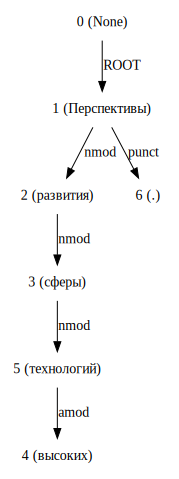

In [ ]:
graph = DependencyGraph(tree_str=sents[0])
graph

## UDPipe

[UDPipe](http://ufal.mff.cuni.cz/udpipe) умеет парсить текст с помощью готовых моделей (которые можно скачать [здесь](https://github.com/jwijffels/udpipe.models.ud.2.0/tree/master/inst/udpipe-ud-2.0-170801)) и обучать модели на своих трибанках.

Собственно, в UDPipe -- это пайплайн из следующих моделей:
* сегментатор и токенизатор (разделить текст на предложения, предложения на токены, сделать заготовку таблицы для для CoNLL-U)
* тэггер (разметить части речи)
* лемматизатор
* сам парсер (сопоставить каждому токену `head` и `deprel`)

Мы сегодня не будем обучать новых моделей (это слишком долго), а используем готовую модель для русского. Кроме русского, у UDPipe есть модели [для многих других языков]((https://github.com/jwijffels/udpipe.models.ud.2.0/tree/master/inst/udpipe-ud-2.0-170801)). 

### The Python binding

UDPipe можно использовать через command-line interface и с помощью питоновской обвязки. Она довольно [плохо задокументирована](https://pypi.org/project/ufal.udpipe/), но зато можно использовать прямо в питоне, поэтому сегодня воспользуемся ей :)

In [ ]:
!pip install ufal.udpipe

     |████████████████████████████████| 307kB 8.7MB/s 
  Created wheel for ufal.udpipe: filename=ufal.udpipe-1.2.0.3-cp37-cp37m-linux_x86_64.whl size=5626595 sha256=ba327db04d290b93165b0305f558265e39a09e8a18eb422ea4e60ffc8910c000
  Stored in directory: /root/.cache/pip/wheels/0c/9d/db/6d3404c33da5b7adb6c6972853efb6a27649d3ba15f7e9bebb
Successfully built ufal.udpipe


In [ ]:
from ufal.udpipe import Model, Pipeline

Скачиваем легкую (хоть и не очень хорошую) модель для русского:

In [ ]:
!wget https://github.com/jwijffels/udpipe.models.ud.2.0/raw/master/inst/udpipe-ud-2.0-170801/russian-ud-2.0-170801.udpipe

--2021-03-24 22:06:11--  https://github.com/jwijffels/udpipe.models.ud.2.0/raw/master/inst/udpipe-ud-2.0-170801/russian-ud-2.0-170801.udpipe
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jwijffels/udpipe.models.ud.2.0/master/inst/udpipe-ud-2.0-170801/russian-ud-2.0-170801.udpipe [following]
--2021-03-24 22:06:11--  https://raw.githubusercontent.com/jwijffels/udpipe.models.ud.2.0/master/inst/udpipe-ud-2.0-170801/russian-ud-2.0-170801.udpipe
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13265262 (13M) [application/octet-stream]
Saving to: ‘russian-ud-2.0-170801.udpipe’

russian-ud-2.0-1708

Загружаем модель

In [ ]:
model = Model.load("russian-ud-2.0-170801.udpipe") # path to the model

In [ ]:
# если успех, должно быть так (model != None)
model

<Swig Object of type 'model *' at 0x7f34e1782df0>

In [ ]:
pipeline = Pipeline(model, 'generic_tokenizer', '', '', '')
example = """А кто уроки не учил,
Тому несдобровать в ночи.
Кто плохо ел и поздно лег,
К тому приходит русский рок"""
parsed = pipeline.process(example)
print(parsed)

# newdoc
# newpar
# sent_id = 1
# text = А кто уроки не учил, Тому несдобровать в ночи.
1	А	А	CCONJ	CC	_	5	cc:preconj	_	_
2	кто	кТО	PRON	WP	Animacy=Anim|Case=Nom|Gender=Masc|Number=Sing	5	nsubj	_	_
3	уроки	уроки	NOUN	NN	Animacy=Anim|Case=Nom|Gender=Masc|Number=Plur	5	nsubj	_	_
4	не	НЕ	PART	NEG	Polarity=Neg	5	advmod	_	_
5	учил	учил	VERB	VBC	Aspect=Perf|Gender=Masc|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin	0	root	_	SpaceAfter=No
6	,	,	PUNCT	,	_	8	punct	_	SpacesAfter=\n
7	Тому	ТОТ	SCONJ	IN	_	8	mark	_	_
8	несдобровать	несдобровать	VERB	VB	Aspect=Imp|VerbForm=Inf	5	xcomp	_	_
9	в	В	ADP	IN	_	10	case	_	_
10	ночи	НОЧЬ	NOUN	NN	Animacy=Inan|Case=Gen|Gender=Fem|Number=Sing	8	obl	_	SpaceAfter=No
11	.	.	PUNCT	.	_	5	punct	_	SpacesAfter=\n

# sent_id = 2
# text = Кто плохо ел и поздно лег, К тому приходит русский рок
1	Кто	КТО	PRON	WP	Animacy=Anim|Case=Nom|Gender=Masc|Number=Sing	3	nsubj	_	_
2	плохо	ПЛОХО	ADV	RB	_	3	advmod	_	_
3	ел	ел	VERB	VBC	Aspect=Imp|Gender=Masc|Mood=Ind|Number=Sing|Tense=Past|

Как видим, UDPipe и токенизировал, и лематизировал текст, сделал POS-tagging и, собственно, синтаксический парсинг.

Можно скопировать и вставить предложения в [онлайн-визуализатор](https://maryszmary.github.io/ud-annotatrix/standalone/annotator.html), чтобы посмотреть, что вышло.

## Natasha

Natasha так же умеет делать синтаксический парсинг для русского языка:

In [ ]:
!pip install natasha

     |████████████████████████████████| 34.4MB 75kB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 8.2MB 29.5MB/s 
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26102 sha256=41e0d4571e16b8a73737406985530d0d2a96e034384e44d5b8347852e6d2c636
  Stored in directory: /root/.cache/pip/wheels/f3/f2/66/e9c30d3e9499e65ea2fa0d07c002e64de63bd0adaa49c445bf
Successfully built intervaltree
  Found existing installation: intervaltree 2.1.0
    Uninstalling intervaltree-2.1.0:
      Successfully uninstalled intervaltree-2.1.0


In [ ]:
from natasha import Doc, NewsEmbedding, NewsSyntaxParser, Segmenter

In [ ]:
example = "Я смотрел, как Си-лучи мерцают во тьме близ врат Тангейзера. Все эти мгновения исчезнут во времени, как слёзы под дождём. "
doc = Doc(example)
doc

Doc(text='Я смотрел, как Си-лучи мерцают во тьме близ врат ...)

Предварительный (и обязательный!) этап - сплиттинг (разбиение на предложения):

In [ ]:
segmenter = Segmenter()

doc.segment(segmenter)
doc.sents

[DocSent(stop=60, text='Я смотрел, как Си-лучи мерцают во тьме близ врат ..., tokens=[...]),
 DocSent(start=61, stop=121, text='Все эти мгновения исчезнут во времени, как слёзы ..., tokens=[...])]

In [ ]:
emb = NewsEmbedding()
syntax_parser = NewsSyntaxParser(emb)

In [ ]:
doc.parse_syntax(syntax_parser)

In [ ]:
display(doc.tokens)

[DocToken(stop=1, text='Я', id='1_1', head_id='1_2', rel='nsubj'),
 DocToken(start=2, stop=9, text='смотрел', id='1_2', head_id='1_0', rel='root'),
 DocToken(start=9, stop=10, text=',', id='1_3', head_id='1_6', rel='punct'),
 DocToken(start=11, stop=14, text='как', id='1_4', head_id='1_6', rel='mark'),
 DocToken(start=15, stop=22, text='Си-лучи', id='1_5', head_id='1_6', rel='obj'),
 DocToken(start=23, stop=30, text='мерцают', id='1_6', head_id='1_2', rel='ccomp'),
 DocToken(start=31, stop=33, text='во', id='1_7', head_id='1_10', rel='case'),
 DocToken(start=34, stop=38, text='тьме', id='1_8', head_id='1_6', rel='obl'),
 DocToken(start=39, stop=43, text='близ', id='1_9', head_id='1_10', rel='case'),
 DocToken(start=44, stop=48, text='врат', id='1_10', head_id='1_11', rel='amod'),
 DocToken(start=49, stop=59, text='Тангейзера', id='1_11', head_id='1_10', rel='nmod'),
 DocToken(start=59, stop=60, text='.', id='1_12', head_id='1_2', rel='punct'),
 DocToken(start=61, stop=64, text='Все', i

In [ ]:
doc.sents[0].syntax.print()

        ┌► Я          nsubj
┌─┌─────└─ смотрел    
│ │ ┌────► ,          punct
│ │ │ ┌──► как        mark
│ │ │ │ ┌► Си-лучи    obj
│ └►└─└─└─ мерцают    ccomp
│ ┌►│      во         case
│ │ └────► тьме       obl
│ │     ┌► близ       case
│ └─┌─┌►└─ врат       amod
│   └►└─── Тангейзера nmod
└────────► .          punct


In [ ]:
doc.sents[1].syntax.print()

      ┌──► Все       det
      │ ┌► эти       det
      └─└─ мгновения nsubj
┌───┌─└─── исчезнут  
│   │   ┌► во        case
│ ┌─└──►└─ времени   obl
│ │   ┌──► ,         punct
│ │   │ ┌► как       case
│ └►┌─└─└─ слёзы     acl
│   │   ┌► под       case
│   └──►└─ дождём    nmod
└────────► .         punct


Можно посмотреть на детали разбора:

In [ ]:
doc.sents[0].syntax.tokens[3]

SyntaxToken(
    id='1_4',
    text='как',
    head_id='1_6',
    rel='mark'
)

## Доп. материал

* [статья про синтаксический пробинг BERT](https://nlp.stanford.edu//~johnhew//structural-probe.html)